In [1]:
%load_ext autoreload
%autoreload 2

In [ ]:
from sys import stdout
import pandas as pd
from plotnine import *

In [ ]:
from utils import salt_bridge_df, h2_detail_load_preprocess, h2_occupancy_viz, inter_chain_selection, plot_salt_bridge_grid_charts, sb_extract_residues, h2_occupancy_viz_overlap_avg

In [4]:
name = '4l72'

Step 1: Generate salt bridge analysis using VMD

1. Combine all trajectory files in dcd to one dcd file using dcd_combine.tcl file
2. Load the cleaned raw pdb file to VMD 
3. Load the combined dcd file over the raw file (load data into molecule)
4. Analyis -> Salt bridge analysis

Step 2: Calculate Hbonds using VMD

1. Load the cleaned raw pdb file to VMD 
2. Load the combined dcd file over the raw file (load data into molecule)
3. Analyis -> H bonds calculations

In [1]:
ROOT = 'results/md_simulations_mers'

## Step 3: Salt bridge selection (only inter chains)

#### Simulation 1 - 200ns, 5M step size, 5M x 100 = 500M timesteps, 500M x 2fs=1000 ns

In [5]:
simulation_numbers = [1, 2, 3]
step_size = 5_000_000

In [ ]:
def salt_bridge_interchain_selection(step_size, simulation_numbers):

    sb_df_all = pd.DataFrame()
    for simulation_num in simulation_numbers:

        SUB_ROOT = f'{ROOT}/simulation_{simulation_num}'
        sb_path = f'{SUB_ROOT}/salt_bridge_files'
        sb_interchain_path = f'{SUB_ROOT}/salt_bridge_interchain'

        #select inter chain salt bridges only
        inter_chain_selection(sb_path, sb_interchain_path)

        #build a dataframe of those results and combine
        sb_df1 = salt_bridge_df(sb_interchain_path, step_size, f'Simulation {simulation_num}')
        sb_df_all = pd.concat([sb_df_all, sb_df1]).reset_index(drop=True)

    print("Combined SB df shape", sb_df_all.shape)
    sb_df_all.to_csv(f'{SUB_ROOT}/salt_bridge_all_df.csv', index=False)

    return sb_df_all

binding affinity

Note: 
- The interaction is considered significant if the distance between the oppositely charged groups is 4 Å or less.
- Salt bridge distances calculated by searching ion pairs with O-N distances (with cutoff range - 4.0A)
- Find only inter chain hbonds
occupancy >= 100% for same chain hbonds

In [8]:
sb_df_all = salt_bridge_interchain_selection(step_size, simulation_numbers)

Inter chain salt bridges save in, /Users/pradyumnakumar/Documents/masters/ksu/assistantship/xlab/md_simulations/results_4l72_1/salt_bridge_interchain
Inter chain salt bridges save in, /Users/pradyumnakumar/Documents/masters/ksu/assistantship/xlab/md_simulations/results_4l72_1/salt_bridge_interchain
Inter chain salt bridges save in, /Users/pradyumnakumar/Documents/masters/ksu/assistantship/xlab/md_simulations/results_4l72_1/salt_bridge_interchain
Inter chain salt bridges save in, /Users/pradyumnakumar/Documents/masters/ksu/assistantship/xlab/md_simulations/results_4l72_1/salt_bridge_interchain
Inter chain salt bridges save in, /Users/pradyumnakumar/Documents/masters/ksu/assistantship/xlab/md_simulations/results_4l72_1/salt_bridge_interchain
Inter chain salt bridges save in, /Users/pradyumnakumar/Documents/masters/ksu/assistantship/xlab/md_simulations/results_4l72_1/salt_bridge_interchain
Inter chain salt bridges save in, /Users/pradyumnakumar/Documents/masters/ksu/assistantship/xlab/md_

In [9]:
sb_df_all.loc[sb_df_all['funnel'] == 'Simulation 1', ['sb_name', 'funnel']].value_counts()

sb_name                      funnel      
ASP129_chainB-ARG279_chainA  Simulation 1    102
ASP158_chainB-LYS229_chainA  Simulation 1    102
ASP259_chainA-ARG161_chainB  Simulation 1    102
ASP355_chainA-ARG130_chainB  Simulation 1    102
ASP74_chainB-ARG298_chainA   Simulation 1    102
GLU194_chainA-ARG161_chainB  Simulation 1    102
Name: count, dtype: int64

In [87]:
sb_df_all['sb_name'].unique()

array(['ASP259_chainA-ARG161_chainB', 'GLU194_chainA-ARG161_chainB',
       'ASP355_chainA-ARG130_chainB', 'ASP129_chainB-ARG279_chainA',
       'ASP158_chainB-LYS229_chainA', 'ASP74_chainB-ARG298_chainA',
       'GLU294_chainA-LYS72_chainB', 'ASP288_chainA-LYS121_chainB'],
      dtype=object)

In [ ]:
# First, find sb_names that appear in multiple funnels (overlaps)
overlap_names = sb_df_all.groupby('sb_name')['funnel'].nunique()
overlap_names = overlap_names[overlap_names > 1].index

# Filter for only overlapping sb_names and calculate average sb_val
result = (sb_df_all[sb_df_all['sb_name'].isin(overlap_names)]
          .groupby(['sb_name', 'funnel'])['sb_val']
          .mean()
          .reset_index())

## Step 4. Data prep for Salt bridges viz

In [12]:
#to get salt bridge which overlap atleast more than one simulation

sb_df_all_refined = sb_df_all.groupby('sb_name').filter(lambda x: x['funnel'].nunique() > 1).reset_index(drop=True)

In [14]:
# extract, store chain A and chain B residues in columns
sb_df_all_refined[['chainA_residue', 'chainB_residue']] = sb_df_all_refined['sb_name'].apply(sb_extract_residues)

In [47]:
sb_df_all_refined.head()

,frames,sb_val,sb_name,timestamp,funnel,chainA_residue,chainB_residue
0,0,7.129480,ASP259_chainA-ARG161_chainB,0.0,Simulation 1,ASP259,ARG161
1,1,7.129480,ASP259_chainA-ARG161_chainB,10.0,Simulation 1,ASP259,ARG161
2,2,4.929944,ASP259_chainA-ARG161_chainB,20.0,Simulation 1,ASP259,ARG161
3,3,11.280400,ASP259_chainA-ARG161_chainB,30.0,Simulation 1,ASP259,ARG161
4,4,8.635868,ASP259_chainA-ARG161_chainB,40.0,Simulation 1,ASP259,ARG161


In [15]:
# renumbering the amino acids numbering to original numbering for chain_A (original_numbering = start_index + (current_numbering - 1))
sb_df_all_refined['chainA_residue_orig'] = sb_df_all_refined['chainA_residue'].apply(lambda x: x[:3] + (str(39 + (int(x[3:])) - 1)))

In [16]:
# renumbering the amino acids numbering to original numbering for chain_B (original_numbering = start_index + (current_numbering - 1))
sb_df_all_refined['chainB_residue_orig'] = sb_df_all_refined['chainB_residue'].apply(lambda x: x[:3] + (str(382 + (int(x[3:])) - 1)))

In [17]:
#building string 'chainB:chainA' for viz
sb_df_all_refined["virus_human"] = sb_df_all_refined['chainB_residue_orig'] + " : " + sb_df_all_refined['chainA_residue_orig']

In [18]:
sb_df_all_refined['virus_human'][0]

'ARG542 : ASP297'

In [53]:
sb_df_all_refined['chainB_residue_number'] = sb_df_all_refined['chainB_residue_orig'].apply(lambda x: int(x[3:]))

In [54]:
sb_df_all_refined = sb_df_all_refined.sort_values(['chainB_residue_number', 'funnel'], ascending=True).reset_index(drop=True)

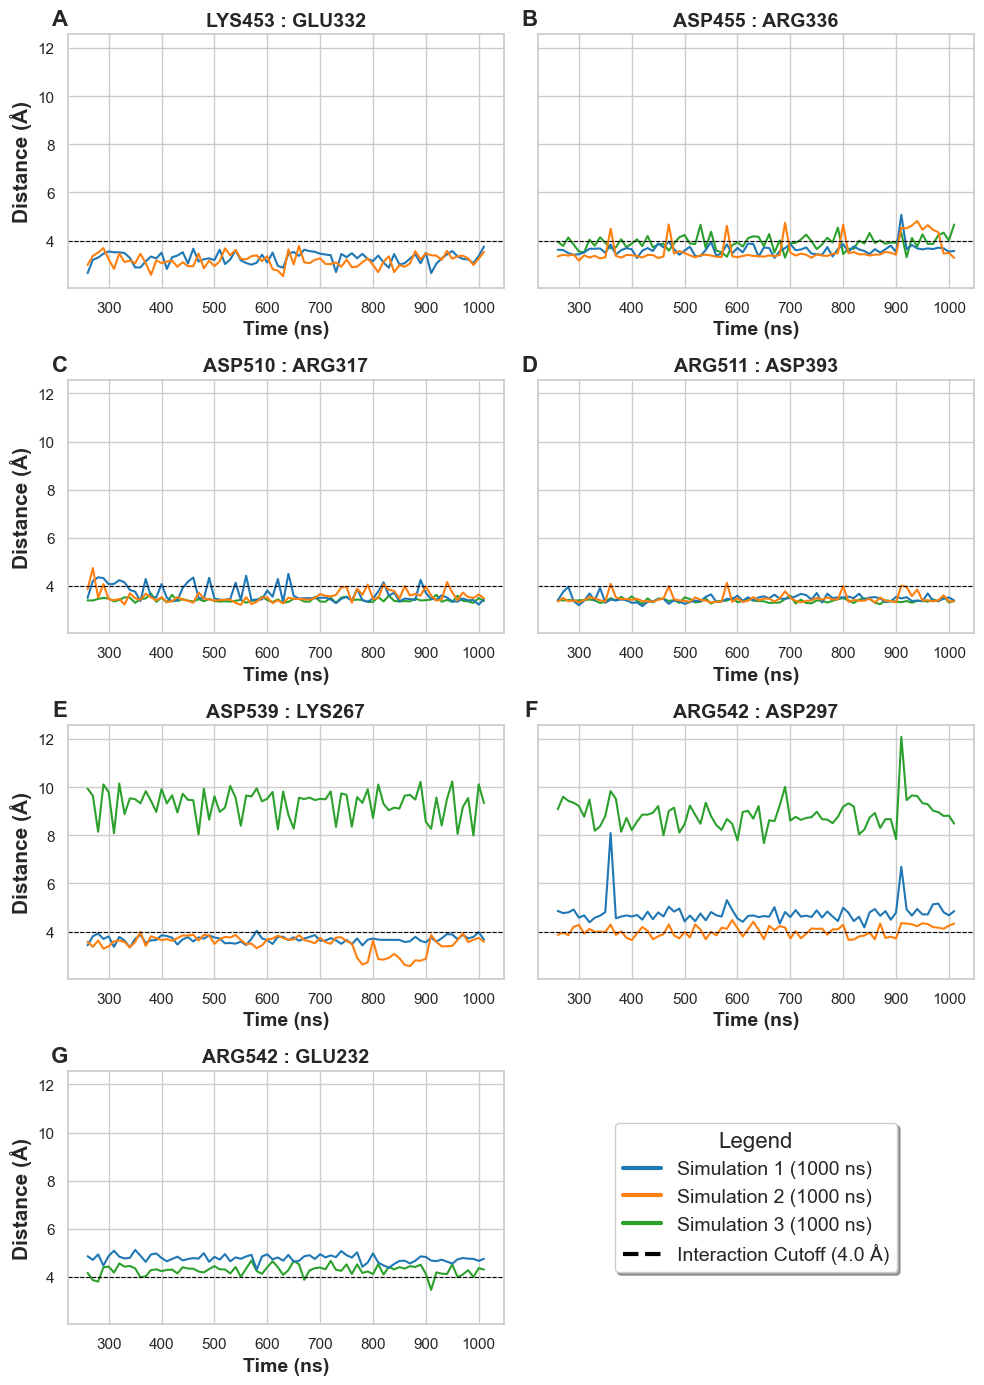

In [81]:
plot_salt_bridge_grid_charts(sb_df_all_refined, 1000)

#### Calculating average distances between common residues

In [90]:
sb_avg_residues = sb_df_all_refined.groupby(['funnel', 'virus_human'])['sb_val'].mean().to_frame().reset_index()

In [91]:
sb_avg_residues.to_csv("sb_avg_residues_1000ns.csv", index=False)

## Step 5: H-bonds inter chain calculations

Config: 4.0A 20 deg
chain A chain B

In [ ]:
def hbonds_analysis():
    simulation_numbers = [1, 2, 3]
    h2_detail_df_all = pd.DataFrame()
    
    for simulation_num in simulation_numbers:
        SUB_ROOT = f'{ROOT}/simulation_{simulation_num}'
        h2_detail_path = f'{SUB_ROOT}/hydrogen_bonds/hbonds-details.dat'
        h2_detail_df = h2_detail_load_preprocess(h2_detail_path, simulation_num)
        h2_occupancy_viz(h2_detail_df, simulation_num)
        h2_detail_df_all = pd.concat([h2_detail_df_all, h2_detail_df]).reset_index(drop=True)

    return h2_detail_df_all

/Users/pradyumnakumar/Documents/masters/ksu/assistantship/xlab/md_simulations/utils.py:379: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


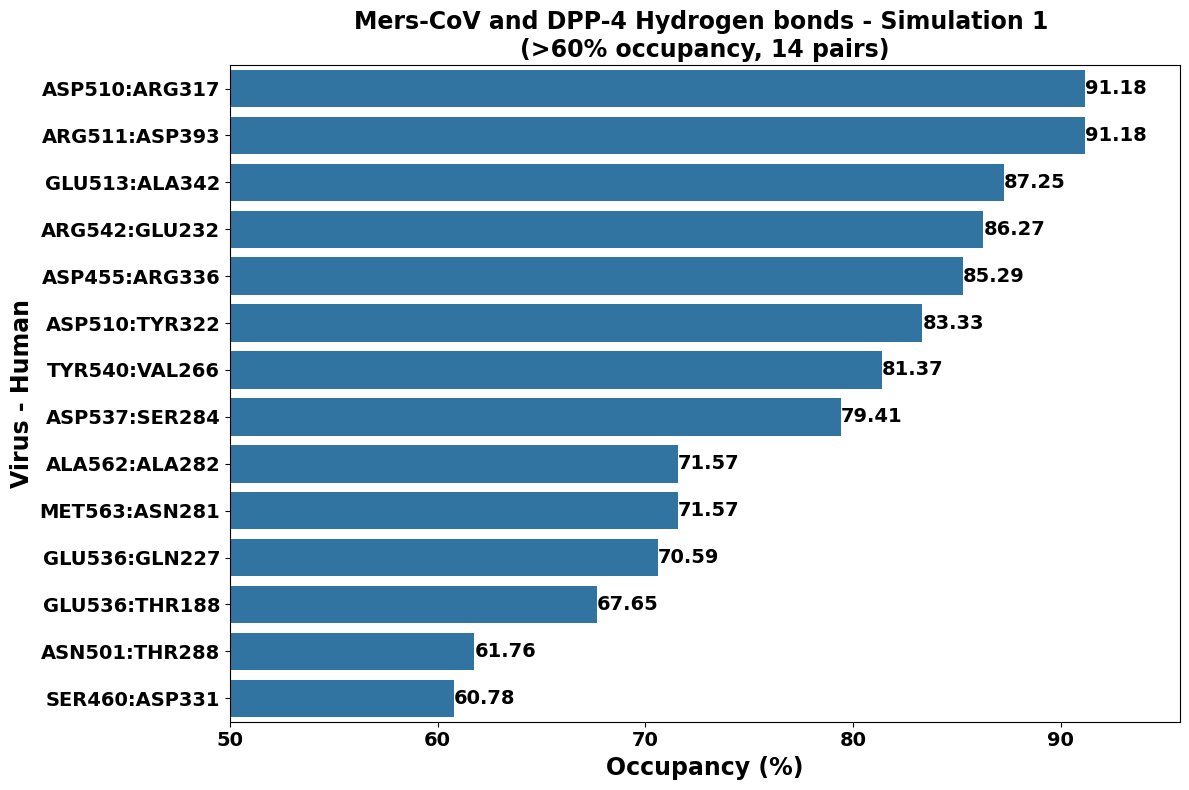

/Users/pradyumnakumar/Documents/masters/ksu/assistantship/xlab/md_simulations/utils.py:379: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


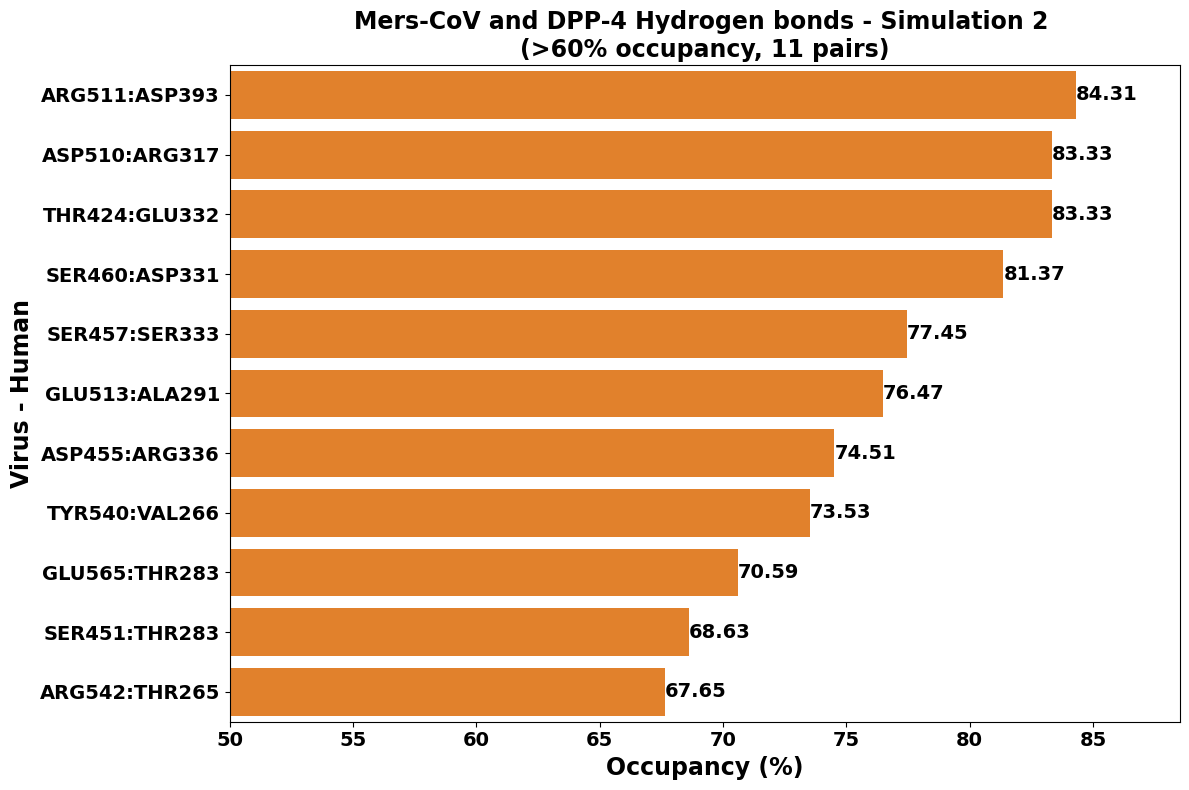

/Users/pradyumnakumar/Documents/masters/ksu/assistantship/xlab/md_simulations/utils.py:379: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.


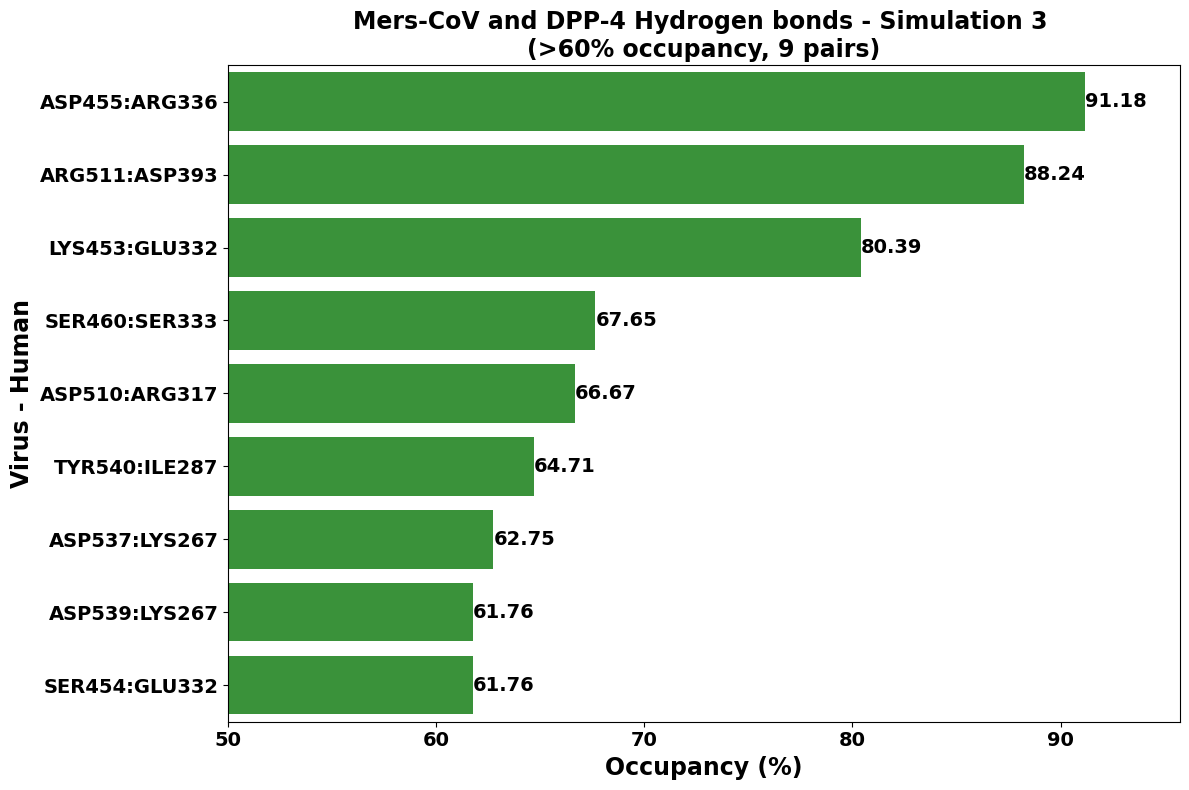

In [32]:
h2_detail_all = hbonds_analysis()

### Calculate average occupancy across simulations

In [33]:
h2_detail_all_da_funnel_grouped = h2_detail_all.groupby('Donor - Acceptor')['funnel'].aggregate('unique')

In [34]:
h2_detail_all_da_funnel_grouped = pd.DataFrame(h2_detail_all_da_funnel_grouped).reset_index(drop=False)
h2_detail_all_da_funnel_grouped['funnel_count'] = h2_detail_all_da_funnel_grouped['funnel'].apply(lambda x: len(x))

In [36]:
h2_detail_all_da_funnel_grouped_com = h2_detail_all_da_funnel_grouped.loc[h2_detail_all_da_funnel_grouped['funnel_count'] > 2].reset_index(drop=True)

In [37]:
h2_detail_all_common = h2_detail_all.merge(h2_detail_all_da_funnel_grouped_com[['Donor - Acceptor', 'funnel_count']], on='Donor - Acceptor', how='right')

In [38]:
h2_detail_all_common.loc[h2_detail_all_common['Donor - Acceptor'] == 'ASP455:ARG336']

,donor,acceptor,occupancy,donor_chain_B,acceptor_chain_A,Donor - Acceptor,funnel,funnel_count
63,SegA-ARG298-Side,SegB-ASP74-Side,85.29,ASP455,ARG336,ASP455:ARG336,Simulation 1,3
64,SegA-ARG298-Side,SegB-ASP74-Main,1.96,ASP455,ARG336,ASP455:ARG336,Simulation 1,3
65,SegA-ARG298-Side,SegB-ASP74-Side,74.51,ASP455,ARG336,ASP455:ARG336,Simulation 2,3
66,SegA-ARG298-Side,SegB-ASP74-Side,91.18,ASP455,ARG336,ASP455:ARG336,Simulation 3,3


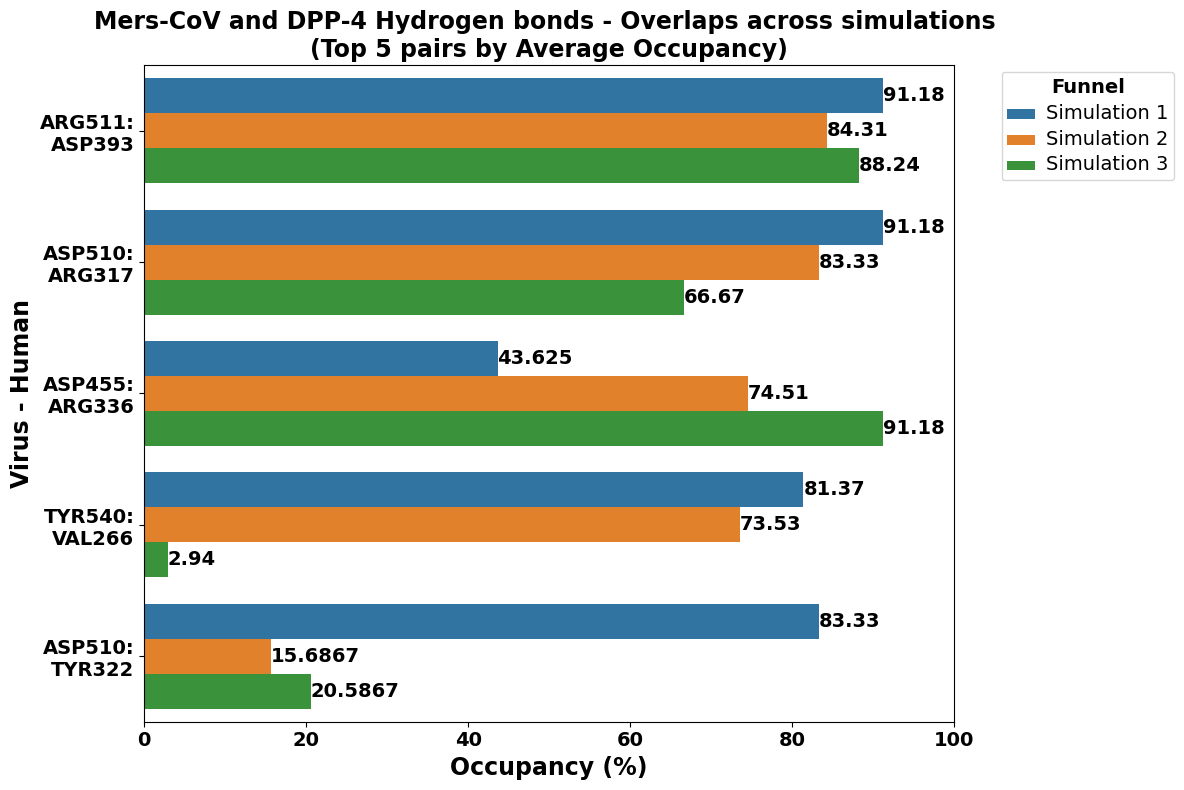

In [41]:
#1000ns
h2_occupancy_viz_overlap_avg(h2_detail_all_common)

In [ ]:
h2_detail_all_50.to_csv("results_csv/h2_all_50.csv", index=False)

In [ ]:
# LYS453 GLU332 3.70*
# ASP455 ARG336 3.74
# ASP510 ARG317 3.56
# ARG511 ASP393 3.63
# ASP539 LYS267 5.43
# ARG542 ASP297 5.96
# ARG542 GLU232 4.77*